In [1]:
from transformers import AutoModelForImageClassification, ViTImageProcessor, ViTForImageClassification
from timm.data.transforms_factory import create_transform
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print cuda device information
print(torch.cuda.get_device_name(0))


NVIDIA GeForce RTX 4090


In [2]:
model = AutoModelForImageClassification.from_pretrained(
    "nvidia/MambaVision-B-1K",
    num_labels=100,
    id2label={i: str(i) for i in range(100)},
    label2id={str(i): i for i in range(100)},
    ignore_mismatched_sizes=True,
    trust_remote_code=True)
# Check the model's architecture to find the classification head
model.model.head = nn.Linear(in_features=model.model.head.in_features, out_features=100, bias=True)
model.to(device)

/root/miniconda3/envs/mamba/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/root/miniconda3/envs/mamba/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/root/miniconda3/envs/mamba/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/root/miniconda3/envs/mamba/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` i

MambaVisionModelForImageClassification(
  (model): MambaVision(
    (patch_embed): PatchEmbed(
      (proj): Identity()
      (conv_down): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (levels): ModuleList(
      (0): MambaVisionLayer(
        (blocks): ModuleList(
          (0): ConvBlock(
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): GELU(approximate='tanh')
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padd

In [3]:
input_resolution = (3, 224, 224)  # MambaVision supports any input resolutions
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=model.config.mean, std=model.config.std),
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=model.config.mean, std=model.config.std),
])

In [4]:
# Load CIFAR-100 Dataset
train_dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs):
    train_acc = []
    test_acc = []
    for epoch in range(num_epochs):
        # Initialize a new progress bar for each epoch
        progress_bar = tqdm(total=len(train_loader) + len(test_loader), desc=f"Epoch {epoch + 1}/{num_epochs} - Train Acc: 0.000 - Val Acc: 0.000", unit="batch")
        
        # Initialize variables for training phase
        train_correct = 0
        train_total = 0
        
        # Training Phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs['logits'], labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs['logits'].max(1)
            train_correct += predicted.eq(labels).sum().item()
            train_total += labels.size(0)
            
            # Update training accuracy
            train_accuracy = train_correct / train_total
            progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} - Train Acc: {train_accuracy:.4f}")
            progress_bar.update(1)  # Update progress bar for each training batch
        
        train_acc.append(train_accuracy)

        # Initialize variables for validation phase
        val_correct = 0
        val_total = 0
        
        # Validation Phase
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs['logits'], labels)
                
                _, predicted = outputs['logits'].max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)
                
                # Update validation accuracy
                val_accuracy = val_correct / val_total
                progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} - Train Acc: {train_accuracy:.4f} - Val Acc: {val_accuracy:.4f}")
                progress_bar.update(1)  # Update progress bar for each validation batch

        test_acc.append(val_accuracy)

        # Reset the progress bar description for the next epoch
        progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} - Train Acc: {train_accuracy:.4f} - Val Acc: {val_accuracy:.4f}")
        progress_bar.close()
        
    return train_acc, test_acc

# Call the function
num_epochs = 5
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
train_acc, test_acc = train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs)

# Save the Fine-Tuned Model
model.save_pretrained("./mambavision-finetuned-cifar100")

Epoch 1/5 - Train Acc: 0.000 - Val Acc: 0.000:   0%|          | 0/1876 [00:00<?, ?batch/s]

Epoch 2/5 - Train Acc: 0.000 - Val Acc: 0.000:   0%|          | 0/1876 [00:00<?, ?batch/s]

Epoch 3/5 - Train Acc: 0.000 - Val Acc: 0.000:   0%|          | 0/1876 [00:00<?, ?batch/s]

Epoch 4/5 - Train Acc: 0.000 - Val Acc: 0.000:   0%|          | 0/1876 [00:00<?, ?batch/s]

Epoch 5/5 - Train Acc: 0.000 - Val Acc: 0.000:   0%|          | 0/1876 [00:00<?, ?batch/s]

In [6]:
# print table of train and test accuracy
print("Epoch\tTrain Acc\tTest Acc")
for i in range(num_epochs):
    print(f"{i + 1}\t{train_acc[i]:.4f}\t{test_acc[i]:.4f}")


Epoch	Train Acc	Test Acc
1	0.7454	0.8454
2	0.8704	0.8563
3	0.9082	0.8496
4	0.9280	0.8621
5	0.9401	0.8688


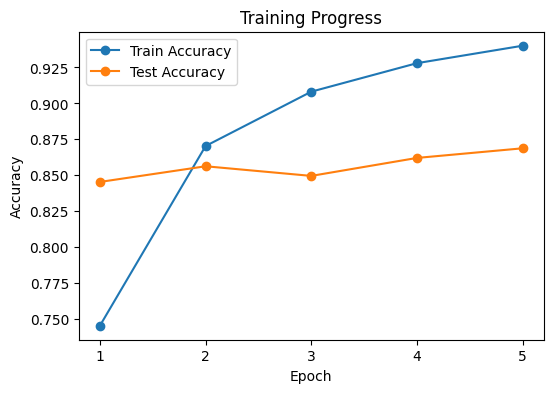

In [7]:
# Plot train and test accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_acc, label="Train Accuracy", marker="o")
plt.plot(range(1, num_epochs + 1), test_acc, label="Test Accuracy", marker="o")
plt.title("Training Progress")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xticks(range(1, num_epochs + 1))
plt.show()

In [8]:
from huggingface_hub import PyTorchModelHubMixin
model.push_to_hub("mambavision-finetuned-cifar100", use_temp_dir=True)

model.safetensors:   0%|          | 0.00/387M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Swapnil949/mambavision-finetuned-cifar100/commit/4ac65d348e99ce2c76a78aa91559cdf4f0fa63a6', commit_message='Upload model', commit_description='', oid='4ac65d348e99ce2c76a78aa91559cdf4f0fa63a6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Swapnil949/mambavision-finetuned-cifar100', endpoint='https://huggingface.co', repo_type='model', repo_id='Swapnil949/mambavision-finetuned-cifar100'), pr_revision=None, pr_num=None)